<a href="https://colab.research.google.com/github/DomjanKatarina/House-Pricing-Kaggle-Competition/blob/main/predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from scipy import stats
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [70]:
# import the train set
df_train = pd.read_csv('https://raw.githubusercontent.com/DomjanKatarina/House-Pricing-Kaggle-Competition/main/Dataset/train.csv', index_col=0)
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [71]:
# import the test set
df_test = pd.read_csv('https://raw.githubusercontent.com/DomjanKatarina/House-Pricing-Kaggle-Competition/main/Dataset/test.csv', index_col=0)
df_test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [72]:
# changing numerical variables to categorical as it should be 
should_be_cat = ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
for var in should_be_cat + list(df_train.select_dtypes(include=['object', 'category']).columns) :
    df_train[var] = df_train[var].astype('category', copy=False)   # Other possible types: 'int64', 'float64', 'object'
    df_test[var] = df_test[var].astype('category', copy=False)

In [73]:
# drop the necesarry columns (previous EDA)
df_train = df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'LotFrontage'])
df_test = df_test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'LotFrontage'])

In [74]:
# adding categories and Boolean variables for Garage, Basement and Pool
garage_var = ['GarageQual', 'GarageType', 'GarageFinish']
for var in garage_var:
    df_train[var] = df_train[var].cat.add_categories(['Missing'])
    df_test[var] = df_test[var].cat.add_categories(['Missing'])
    df_train[var] = df_train[var].fillna('Missing')
    df_test[var] = df_test[var].fillna('Missing')

df_train['Garage'] = [0 if x==0 else 1 for x in df_train['GarageArea']]
df_test['Garage'] = [0 if x==0 else 1 for x in df_test['GarageArea']]
df_train['Garage'] = df_train['Garage'].astype('bool',copy=False)
df_test['Garage'] = df_test['Garage'].astype('bool',copy=False)

bsmt_var = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for var in bsmt_var:
    df_train[var] = df_train[var].cat.add_categories(['MissingBsmt'])
    df_test[var] = df_test[var].cat.add_categories(['MissingBsmt'])
    df_train[var] = df_train[var].fillna('MissingBsmt')
    df_test[var] = df_test[var].fillna('MissingBsmt')

df_train['Bsmt'] = [0 if x==0 else 1 for x in df_train['TotalBsmtSF']]
df_test['Bsmt'] = [0 if x==0 else 1 for x in df_test['TotalBsmtSF']]
df_train['Bsmt'] = df_train['Bsmt'].astype('bool',copy=False)
df_test['Bsmt'] = df_test['Bsmt'].astype('bool',copy=False)

df_train['Pool'] = [0 if x==0 else 1 for x in df_train['PoolArea']]
df_test['Pool'] = [0 if x==0 else 1 for x in df_test['PoolArea']]
df_train['Pool'] = df_train['Pool'].astype('bool',copy=False)
df_test['Pool'] = df_test['Pool'].astype('bool',copy=False)

In [75]:
# updating lists of categorical and numerical variables
cat_var = list(df_train.select_dtypes(include=['object', 'category']).columns) 
cat_var = [var for var in cat_var if (df_train[var].nunique() < 10) or (var in ['Neighborhood', 'MoSold'])]

num_var = list(df_train.select_dtypes(include=['number']).columns)
num_var.remove('SalePrice')

In [76]:
# removing categorical variables that have more categories in test set than in train set
cat_var_1 = cat_var
for var in cat_var_1:
  in_train = set(df_train[var].cat.categories)
  in_test = set(df_test[var].cat.categories)

  missing_categories = list(in_test-in_train)
  if len(missing_categories) != 0:
    df_train.drop(columns=[var])
    df_test.drop(columns=[var])
    cat_var.remove(var)

In [77]:
# dividing the dataframe into independent variables and dependent variable
X = df_train.drop(columns=['SalePrice']).reset_index(drop=True)
y = df_train.SalePrice

# Deep Neural Network

Possible twigs: 
- number of units
- activation function: `relu`, `elu`, `selu`, `swish`
- loss function: MAE, MSE, Huber
- optimizer
- size of minibatches
- learning rate

---

**Tensors and weights** 

Keras represents the weights of a neural network with tensors. Tensors are basically TensorFlow's version of a Numpy array with a few differences that make them better suited to deep learning. One of the most important is that tensors are compatible with GPU and TPU) accelerators. TPUs, in fact, are designed specifically for tensor computations.

Before the model is trained, the weights are set to random numbers and the bias to 0. A neural network learns by finding better values for its weights.

The key idea here is *modularity*, building up a complex network from simpler functional units.

---

**[Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)** 

Neural networks typically organize their neurons into **layers**. When we collect together linear units having a common set of inputs we get a **dense** layer. You could think of each layer in a neural network as performing some kind of relatively simple transformation. Through a deep stack of layers, a neural network can transform its inputs in more and more complex ways. In a well-trained neural network, each layer is a transformation getting us a little bit closer to a solution.

The layers before the output layer are sometimes called **hidden** since we never see their outputs directly.

**Dropout layer** can help correct overfitting. We randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust. You could also think about dropout as creating a kind of ensemble of networks. The predictions will no longer be made by one big network, but instead by a committee of smaller networks. When adding dropout, you may need to increase the number of units in your Dense layers.

**Batch normalization** can help correct training that is slow or unstable. With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. It's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training. You can put it between layers or after the layer (between units and activation or after activation). And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's StandardScaler.

---

**Activation function** 

Two dense layers with nothing in between are no better than a single dense layer by itself. Dense layers by themselves can never move us out of the world of lines and planes. We need something nonlinear: activation functions.

An activation function is simply some function we apply to each of a layer's outputs (its activations). The most common is the *rectifier* function  `max(0,x)`. When we attach the rectifier to a linear unit, we get a rectified linear unit or **ReLU**. Applying a ReLU activation to a linear unit means the output becomes `max(0, w * x + b)`.

Notice that the final (output) layer is a linear unit (meaning, no activation function). That makes this network appropriate to a regression task. Other tasks (like classification) might require an activation function on the output.

---

**Loss function**

The loss function measures the disparity between the the target's true value and the value the model predicts. In other words, we tell the NN what problem to solve.

A common loss functions for regression problems are:
- MAE
- MSE
- Huber loss (less sensitive to outliers).

---

**Optimizer**

The optimizer is an algorithm that adjusts the weights to minimize the loss. In other words, we tell the NN how to solve the problem.

Virtually all of the optimization algorithms used in deep learning belong to a family called **stochastic gradient descent**. They are iterative algorithms that train a network in steps. One step of training goes like this:

1. Sample some training data and run it through the network to make predictions.
2. Measure the loss between the predictions and the true values.
3. Finally, adjust the weights in a direction that makes the loss smaller.

Then just do this over and over until the loss is as small as you like (or until it won't decrease any further.)

---

**Batch and epoch**

**Minibatch (batch)**: Each iteration's sample of training data. 

**Epoch**: a complete round of the training data. The number of epochs you train for is how many times the network will see each training example.

---

**Learning rate**

The size of these shifts towards the best fit is determined by the learning rate. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

The learning rate and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds.

**Adam** is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.

---

**Overfitting and underfitting**

*Underfitting* the training set is when the loss is not as low as it could be because the model hasn't learned enough signal. If it appears that your network is underfitting the data, you should try increasing its capacity. You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). We can use early stopping as well, to give model enough time to learn all the signal it can. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.

*Overfitting* the training set is when the loss is not as low as it could be because the model learned too much noise. We can prevent overfitting with **early stopping**. 



---

**Some hints:**

- Neural networks tend to perform best when their inputs are on a common scale.
- Deciding the architecture of your model should be part of a process. Start simple and use the validation loss as your guide.


In [78]:
# 'MasVnrArea' is causing nans of the network
num_var1 = ['YearBuilt', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
cat_var1 = ['GarageCars', 'Garage', 'Pool', 'Bsmt', 'OverallQual', 'YrSold', 'MoSold', 'Heating', 'HouseStyle']

In [79]:
X = X[['GarageCars', 'TotalBsmtSF', 'GrLivArea', 'Garage', 'Pool', 'Bsmt', 'Neighborhood', 'OverallQual', '1stFlrSF', 'YearBuilt']]

#X = pd.concat([X[num_var1], X[cat_var1]], axis=1)
X['TotalBsmtSF'] = np.log1p(X['TotalBsmtSF'])
X['GrLivArea'] = np.log1p(X['GrLivArea'])
X['1stFlrSF'] = np.log1p(X['1stFlrSF'])
print(X.head(5))
# Try summing 'TotalBsmtSF' and '1stFlrSF'

  GarageCars  TotalBsmtSF  GrLivArea  Garage   Pool  Bsmt Neighborhood  \
0          2     6.753438   7.444833    True  False  True      CollgCr   
1          2     7.141245   7.141245    True  False  True      Veenker   
2          2     6.825460   7.488294    True  False  True      CollgCr   
3          3     6.629363   7.448916    True  False  True      Crawfor   
4          3     7.044033   7.695758    True  False  True      NoRidge   

  OverallQual  1stFlrSF  YearBuilt  
0           7  6.753438       2003  
1           6  7.141245       1976  
2           7  6.825460       2001  
3           7  6.869014       1915  
4           8  7.044033       2000  


In [80]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include='category')),
)

X = preprocessor.fit_transform(X)
y = np.log1p(y)

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [82]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

In [83]:
# Possible activation function and its graphs
"""
activations = ['relu', 'elu', 'selu', 'swish']

for activation in activations:
  activation_layer = layers.Activation(activation)

  x = tf.linspace(-3.0, 3.0, 100)
  y = activation_layer(x) # once created, a layer is callable just like a function

  plt.figure(dpi=100)
  plt.plot(x, y)
  plt.xlim(-3, 3)
  plt.xlabel("Input")
  plt.ylabel("Output")
  plt.title(activation)
  plt.show()
"""

'\nactivations = [\'relu\', \'elu\', \'selu\', \'swish\']\n\nfor activation in activations:\n  activation_layer = layers.Activation(activation)\n\n  x = tf.linspace(-3.0, 3.0, 100)\n  y = activation_layer(x) # once created, a layer is callable just like a function\n\n  plt.figure(dpi=100)\n  plt.plot(x, y)\n  plt.xlim(-3, 3)\n  plt.xlabel("Input")\n  plt.ylabel("Output")\n  plt.title(activation)\n  plt.show()\n'

In [84]:
"""
# Create a network with 1 linear unit
model = keras.Sequential([
    # hidden layers
    layers.Dense(units=512, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(units=512, activation='relu'),
    # the linear output layer
    layers.Dense(units=1)
])

#w, b = model.weights
#print("Weights\n{}\n\nBias\n{}".format(w, b))
"""

'\n# Create a network with 1 linear unit\nmodel = keras.Sequential([\n    # hidden layers\n    layers.Dense(units=512, activation=\'relu\', input_shape=[X_train.shape[1]]),\n    layers.Dense(units=512, activation=\'relu\'),\n    # the linear output layer\n    layers.Dense(units=1)\n])\n\n#w, b = model.weights\n#print("Weights\n{}\n\nBias\n{}".format(w, b))\n'

In [95]:
model = keras.Sequential([
    layers.Dense(units=125, input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Activation('selu'),
    layers.Dense(units=125),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(units=125),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.Dense(units=125),
    layers.Activation('selu'),
    layers.Dense(units=1)
])

# We will not add the dropout layer as it seems our network is underfitting
# layers.Dropout(rate=0.3), # apply 30% dropout to the next layer

In [96]:
# Adding loss function and optimizer
model.compile(
    optimizer="adam",
    loss="mae",
)

In [97]:
# adding early stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [98]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=400,
    epochs=500,
    callbacks = early_stopping,
    verbose = 0  # turn of the training log
)

Minimum validation loss: 0.18403814733028412


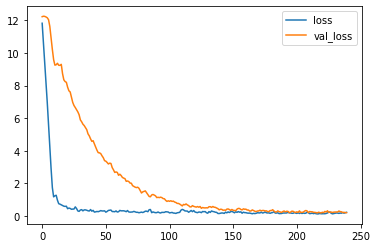

In [99]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
#history_df['loss'].plot()
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# XGBoost

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model (naive predictions). Then, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
- Add the new model to the ensemble and repeat.

---
`n_estimators` specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble. Typical values range from 100-1000, though this depends a lot on the `learning_rate`.

---
`early_stopping_rounds` offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating. Setting `early_stopping_rounds=5` is a reasonable choice.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter.

---
`learning_rate`

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for `n_estimators` without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets `learning_rate=0.1`.

In [100]:
X_xgb = df_train.drop(columns=['SalePrice'])

skewed_feats = X_xgb[num_var].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

X_xgb[skewed_feats] = np.log1p(X_xgb[skewed_feats])

y = df_train.SalePrice
y = np.log1p(y)  # There isn't any data leakage involved as log1p does not learn any parameters such as mean or std from the data

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(X_xgb, y, train_size=0.8, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)

(1168, 74)
(292, 74)


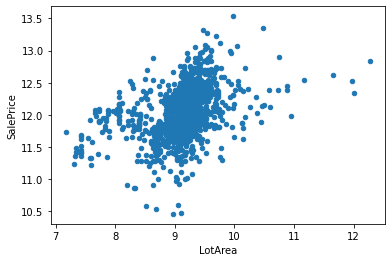

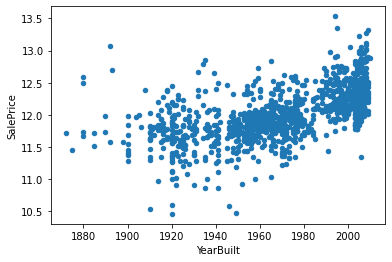

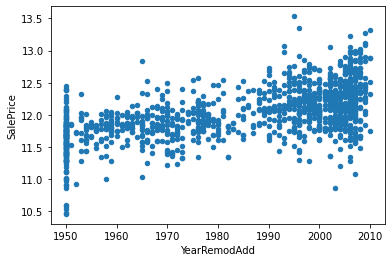

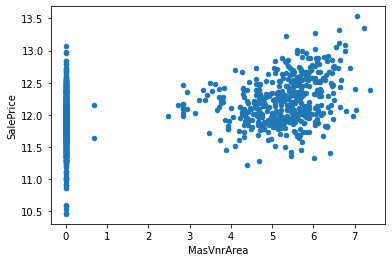

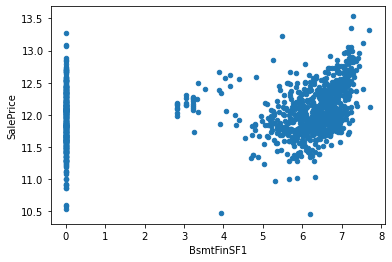

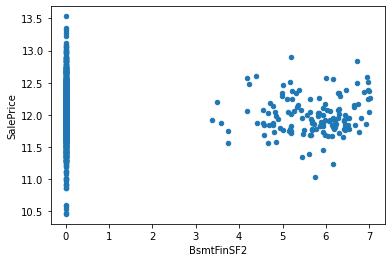

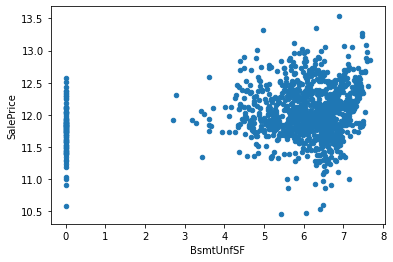

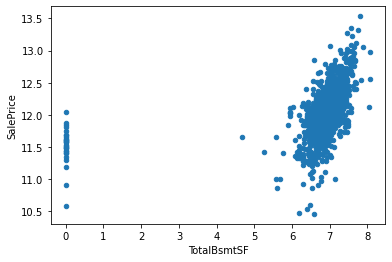

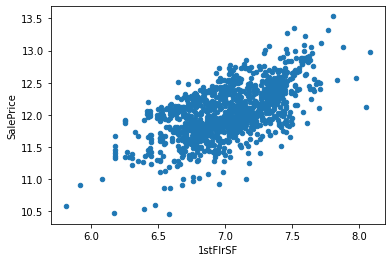

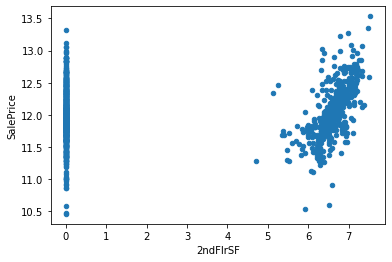

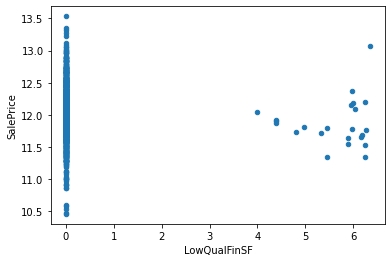

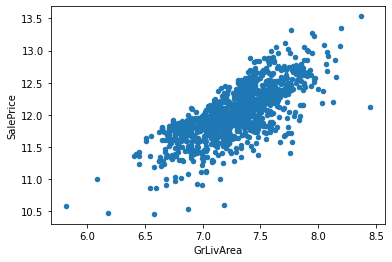

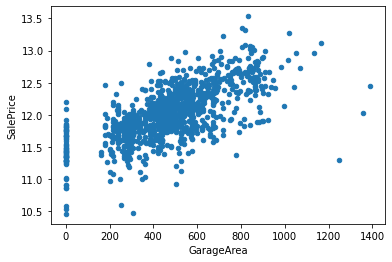

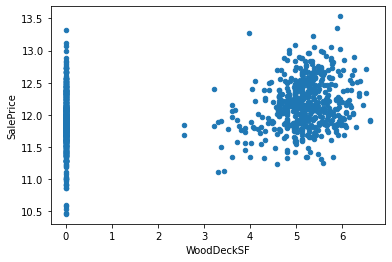

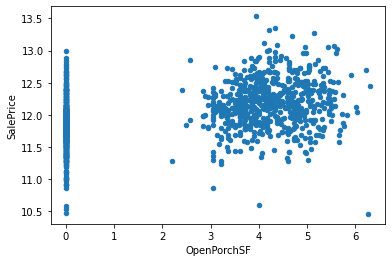

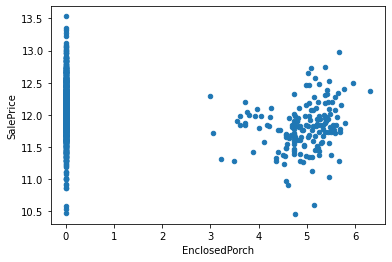

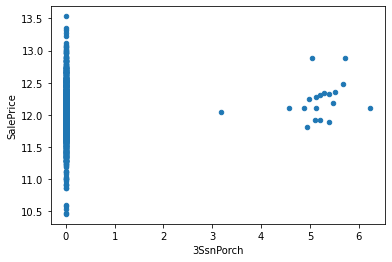

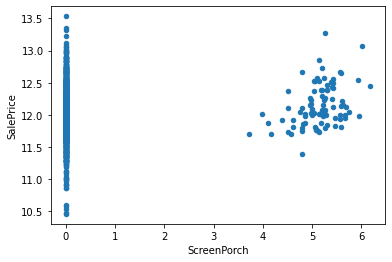

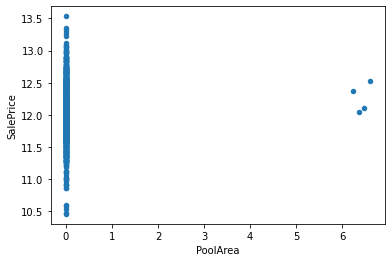

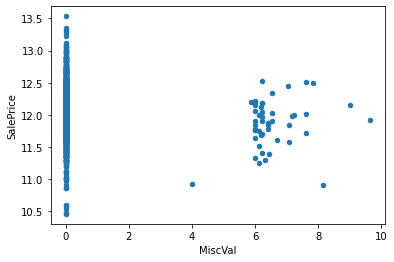

In [102]:
for var in num_var:
  data = pd.concat([y_train, X_train[var]], axis=1)
  data.plot.scatter(x=var, y='SalePrice');

In [103]:
# Delete outliers of 'GrLivArea'
to_drop = list(X_train.index[X_train['GrLivArea']>8.3])
X_train = X_train.drop(labels=to_drop)
y_train = y_train.drop(labels=to_drop)

# Delete outliers of 'GarageArea'
to_drop = list(X_train.index[X_train['GarageArea']>1200])
X_train = X_train.drop(labels=to_drop)
y_train = y_train.drop(labels=to_drop)

# Delete outliers of 'TotalBsmtSF'
# to_drop = list(X_train.index[X_train['TotalBsmtSF']>3000])
#X_train = X_train.drop(labels=to_drop)
#y_train = y_train.drop(labels=to_drop)

In [104]:
num_X_train = X_train[num_var]
num_X_valid = X_valid[num_var]

my_imputer = SimpleImputer(strategy='mean')

num_X_train = pd.DataFrame(my_imputer.fit_transform(num_X_train)).reset_index(drop=True)
num_X_valid = pd.DataFrame(my_imputer.transform(num_X_valid)).reset_index(drop=True)

num_X_train.columns = X_train[num_var].columns
num_X_valid.columns = X_valid[num_var].columns

In [105]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cat_var]))
OH_cols_train.columns = OH_encoder.get_feature_names()
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[cat_var]))
OH_cols_valid.columns = OH_encoder.get_feature_names()

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

OH_cols_train.reset_index(drop=True, inplace=True)
OH_cols_valid.reset_index(drop=True, inplace=True)

In [106]:
X_train = pd.concat([num_X_train, OH_cols_train, X_train[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid, X_valid[['Garage', 'Bsmt', 'Pool']].reset_index(drop=True)], axis=1)

In [107]:
def best_model(param_comb, data):
  X_train, y_train, X_valid, y_valid = data[0], data[1], data[2], data[3]
  mae_final = None
  best_comb = None

  for comb in param_comb:
    model = XGBRegressor(n_estimators=comb[0], learning_rate=comb[1])
    model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

    # Get predictions
    predictions = model.predict(X_valid)
    #mae = mean_absolute_error(np.expm1(predictions), np.expm1(y_valid))
    mae = mean_absolute_error(predictions, y_valid)

    if (mae_final == None) or (mae < mae_final):
      mae_final = mae
      best_comb = comb

    #print("Parameters: " + str(comb))
    #print("Mean Absolute Error: " + str(mae) + "\n")

  return best_comb, mae_final 

In [108]:
xgb_n_estimators = [100, 250, 500, 1000]
xgb_learning_rate = [0.01, 0.05, 0.1, 0.5, 1]

param_comb = list(itertools.product(xgb_n_estimators, xgb_learning_rate))

data = [X_train, y_train, X_valid, y_valid]

best_comb, mae = best_model(param_comb, data)
print("Best parameters: ", best_comb)
print("Best MAE: ", mae)

[12:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
"""
class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self,  X_train, y_train, X_valid, y_valid, 
                 early_stopping_rounds=5, eval_metric='mae', **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.eval_metric=eval_metric=eval_metric      
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.estimator.fit(X_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, 
                           eval_set=[(X_valid, y_valid)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)
"""

In [ ]:
"""
numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_var),
        ('cat', categorical_transformer, cat_var)
    ])
"""

In [ ]:
"""
pipeline = Pipeline([('preprocessor', preprocessor),
    ('xgb', XGBoostRegressorWithEarlyStop(X_train, y_train, X_valid, y_valid))
])

param_grid = {
    "xgb__n_estimators": [100, 250, 500, 100],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
}

grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train, X_valid, y_valid)
print(grid.best_params_)
"""

In [ ]:
"""
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_pipeline = Pipeline([('preprocessor', preprocessor), ('xgbrg', XGBRegressor())])
"""

In [ ]:
"""
param_grid = {
    "xgbrg__n_estimators": [100, 250, 500, 100],
    "xgbrg__learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
}

fit_params = {"xgbrg__eval_set": [(X_valid, y_valid)], 
              "xgbrg__early_stopping_rounds": 5, 
              "xgbrg__verbose": False} 

searchCV = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid, **fit_params=fit_params)
searchCV.fit(X_train, y_train)
"""

## Model Comparison:
We notice that the XGBoost is performing better on the data than Neural Network.